In [1]:
#%pip install tifffile
#%pip install monai
%pip install -q git+https://github.com/huggingface/transformers.git
#%pip install -U ipywidgets==7.7.1


Found existing installation: transformers 4.41.0.dev0
Uninstalling transformers-4.41.0.dev0:
  Successfully uninstalled transformers-4.41.0.dev0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [1]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy import ndimage
import tifffile
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from transformers import SamProcessor
from PIL import Image
import io

In [2]:
sidewalk_train = load_dataset("back2classroom/sidewalks", split='train', streaming=True)
print(next(iter(sidewalk_train)))

sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)
print(next(iter(sidewalk_test)))

{'filename': '1001_10_1', 'tfw': b'1.0000000000\r\n0.0000000000\r\n0.0000000000\r\n1.0000000000\r\n0.0000000000\r\n2304.0000000000\r\n', 'tif': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\

In [ ]:
#test_images = tifffile.imread("/workspaces/csgy6613-project/Test/*.tif")
#test_labels = tifffile.imread("/workspaces/csgy6613-project/Label/Test/*.tif")

In [ ]:
#test_images.shape

In [3]:
test_images = []
test_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]



Empty masks:  9917


In [4]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

# Convert all images and masks
filtered_images_np = [convert_to_numpy(img) for img in filtered_images]
filtered_masks_np = [convert_to_numpy(mask) for mask in filtered_masks]

# Print information about the converted data
if filtered_images_np and filtered_masks_np:
    print("Number of filtered images:", len(filtered_images_np))
    print("Number of filtered masks:", len(filtered_masks_np))
    print("Image shape of the first item:", filtered_images_np[0].shape)
    print("Mask shape of the first item:", filtered_masks_np[0].shape)
else:
    print("No filtered images or masks found")


Number of filtered images: 10082
Number of filtered masks: 10082
Image shape of the first item: (256, 256, 3)
Mask shape of the first item: (256, 256)


In [6]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(test_labels) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = test_images[valid_indices]
filtered_masks = test_labels[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

AttributeError: 'bytes' object has no attribute 'max'

In [5]:
from datasets import Dataset
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images_np],
    "label": [Image.fromarray(mask) for mask in filtered_masks_np],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [6]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10082
})

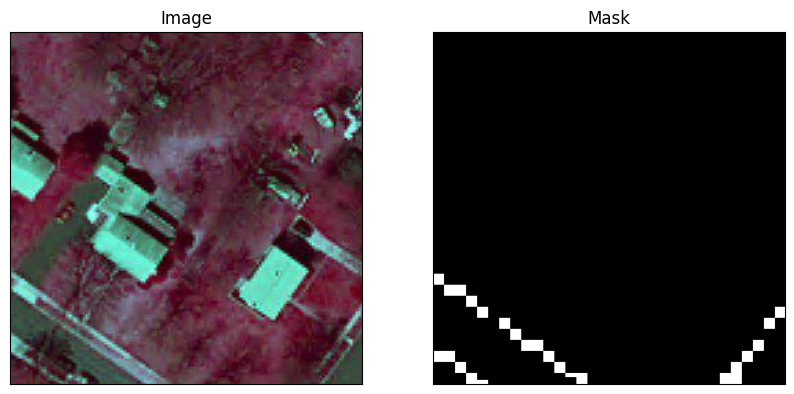

In [10]:
img_num = random.randint(0, filtered_images_np[0].shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [11]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [12]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [13]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [14]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [17]:
train_dataloader = DataLoader (train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items ():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [19]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [20]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
     

RuntimeError: Failed to import transformers.models.sam.modeling_sam because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
/usr/local/lib/python3.10/dist-packages/transformer_engine_extensions.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN2at4_ops5zeros4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEE